In [ ]:
from google.colab import drive
drive.mount('/content/drive')

***Download Packages***

In [ ]:
import nltk
nltk.download('all')

In [ ]:
!pip install nlpaug

***Imports***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop

from nltk.corpus import stopwords
from nltk.util import ngrams
stop=set(stopwords.words('english'))

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

#Data Preprocessing

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset.csv')

In [ ]:
data.shape

(151, 24)

In [ ]:
data.isnull().sum()

Statistiques horaires      0
Page                       0
Catégorie d'appareil       0
Pays                       0
Pages views                0
Vues uniques               0
Average visit time         0
Entries                    0
Rebound rate               0
Departures (in%)           0
Session Lenght             0
TimeToClickInMS            0
SpeedIndex                 0
TTFB                       0
OnLoad                     0
FirstPaint                 0
MOS                        0
net_delay                  0
latency                    0
bandwidht                  0
jitter                     0
id_video                   0
Comment                    0
Unnamed: 23              151
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

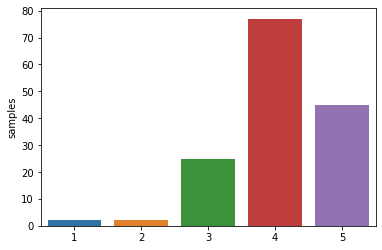

In [ ]:
import seaborn as sns

x=data.MOS.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

As you can see, there more comments with a MOS 4 than the other classes: Our data is unbalanced

In [ ]:
train = data['Comment']
target = data['MOS']

***Data Augmentation***

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=10)

In [ ]:
def augment_text(df, label, num=1):
  augmented_sentences=[]
  augmented_sentences_labels=[]
  for i in df.index:
    if target[i]==label:
      temps=aug.augment(df[i],n=num)
      for sent in temps:
        augmented_sentences.append(sent)
        augmented_sentences_labels.append(label)
  return augmented_sentences, augmented_sentences_labels

In [ ]:
mos1, target1 = augment_text(train, 1, num=30)
train = train.append(pd.Series(mos1), ignore_index=True)
target = target.append(pd.Series(target1), ignore_index=True)

mos2, target2 = augment_text(train, 2, num=35)
train = train.append(pd.Series(mos2), ignore_index=True)
target = target.append(pd.Series(target2), ignore_index=True)

mos3, target3 = augment_text(train, 3, num=2)
train = train.append(pd.Series(mos3), ignore_index=True)
target = target.append(pd.Series(target3), ignore_index=True)

In [ ]:
print(f"Train shape: {train.shape}")
print(f"Target shape: {target.shape}")

Train shape: (331,)
Target shape: (331,)


In [ ]:
data_augmented = pd.DataFrame({'Comment': train,
                               'MOS': target})

#We will shuffle the data and remove duplicates before splitting
data_augmented.drop_duplicates(inplace=True)
data_augmented = data_augmented.sample(frac = 1).reset_index(drop=True)
data_augmented.shape

(262, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

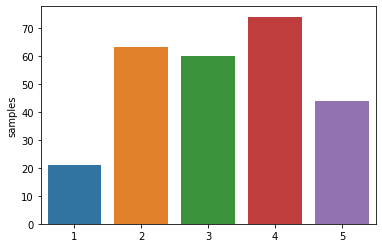

In [ ]:
x=data_augmented.MOS.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

In [ ]:
!pip uninstall pandas
!pip install pandas==1.1.5

data_augmented.to_csv('/content/drive/MyDrive/Colab Notebooks/data_augmented.csv', index=False)

In [ ]:
train = data_augmented['Comment']
target = data_augmented['MOS']

In [ ]:
from tensorflow.keras.utils import to_categorical
target = to_categorical(target)
target = np.array(target).astype('float32')

***Preparing our Data***

We will turn our text into lists of integer indices

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

samples = train

#Create a tokenizer configured to take the 1000 most common words
tokenizer = Tokenizer(num_words=1000)
#Build the word index
tokenizer.fit_on_texts(samples)
#Turn strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(samples)
#get the one-hot binary representations
one_hot_results = tokenizer.texts_to_matrix(samples, mode="binary")

#Recover the word index
word_index = tokenizer.word_index

***Data Splitting***

In [ ]:
x_train = sequences[:200]
y_train = target[:200]

x_test = sequences[200:]
y_test = target[200:]

In [ ]:
print(f'Training data shape: {len(x_train)}')
print(f'Testing data shape: {len(x_test)}')

Training data shape: 200
Testing data shape: 62


In [ ]:
max_features = 10000
max_len = 500

We will **Pad** our Data so that they all have the same length, **turn them into an integer tensor of shape (samples, word_indices)**, and then use as the first layer in your network a layer capable of handling such integer tensors(**Embedding layer** in our case)

In [ ]:
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

Loading & Preparing GloVe for word representation

In [ ]:
import os 

#Parsing the GloVe word-embeddings file

embeddings_index = {}
f = open( '/content/drive/MyDrive/GloVe/glove.6B.100d.txt')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

#Preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_features, embedding_dim))

for word, i in word_index.items():
  if i < max_features:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


#Building & Training the Model

In [ ]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(max_features, 100, input_length=max_len))

model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(64, 7,activation='relu'))

model.add(layers.GRU(64))

model.add(layers.Dense(6, activation="softmax"))

Our model is ready. Let's freeze the Embedding layer to avoid loosing the learned information

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

***Training***

In [ ]:
model.summary()

opt = RMSprop(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 98, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 92, 64)            14400     
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

***Plotting***

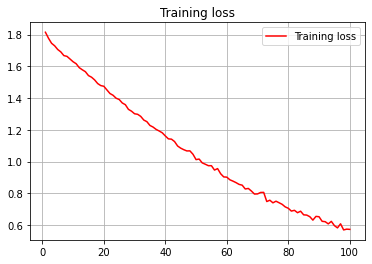

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.grid(True)

plt.show()

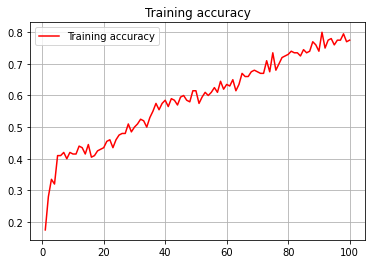

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
result_nn_model = model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 16ms/step - loss: 0.7478 - acc: 0.7258


***We reached 72% accuracy on the testing data***